#Exemplo com dataset pré treinado, demonstrando mapa de atenção

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


A imagem foi classificada como: Egyptian cat
------------------------------


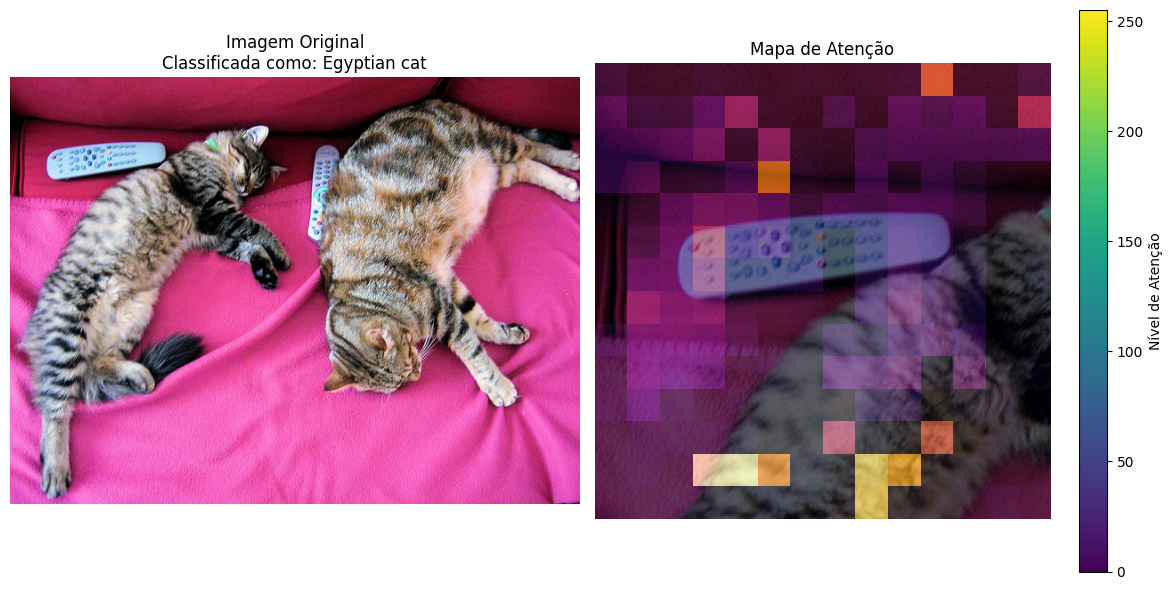

In [ ]:
import torch
import requests
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

# --- Carrega modelo pré-treinado ViT ---
model_name = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

# --- Baixa e abre a imagem ---
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')

# --- Prepara a imagem para o modelo ---
inputs = feature_extractor(images=image, return_tensors="pt")

# --- Faz a classificação ---
with torch.no_grad():  # sem calcular gradientes
    outputs = model(**inputs)
    logits = outputs.logits

# --- Classe prevista ---
predicted_class_idx = logits.argmax(-1).item()
predicted_class = model.config.id2label[predicted_class_idx]
print(f"A imagem foi classificada como: {predicted_class}")
print("-" * 30)

# --- Visualiza a atenção do token CLS ---
outputs_with_attn = model(**inputs, output_attentions=True)
attentions = outputs_with_attn.attentions[-1]  # atenção da última camada

# Média da atenção do token CLS para todos os patches
attention_map = attentions[0, :, 0, 1:].mean(dim=0)
attention_map = attention_map.reshape(14, 14)  # 14x14 patches

# --- Mostra imagem e heatmap de atenção ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image)
ax1.set_title(f'Imagem Original\nClassificada como: {predicted_class}')
ax1.axis('off')

# Sobreposição do mapa de atenção
im = ax2.imshow(image)
ax2.imshow(attention_map.cpu().detach().numpy(), cmap='inferno', alpha=0.6, extent=(0, 224, 224, 0))
ax2.set_title('Mapa de Atenção')
ax2.axis('off')
fig.colorbar(im, ax=ax2, label='Nível de Atenção')

plt.tight_layout()
plt.show()

#Exemplo para demonstrar o mapa de atenção ao classificar imagens aleatórias

Carregando o dataset cifar10...
Classe Real: bird
Previsão do ViT: ostrich, Struthio camelus


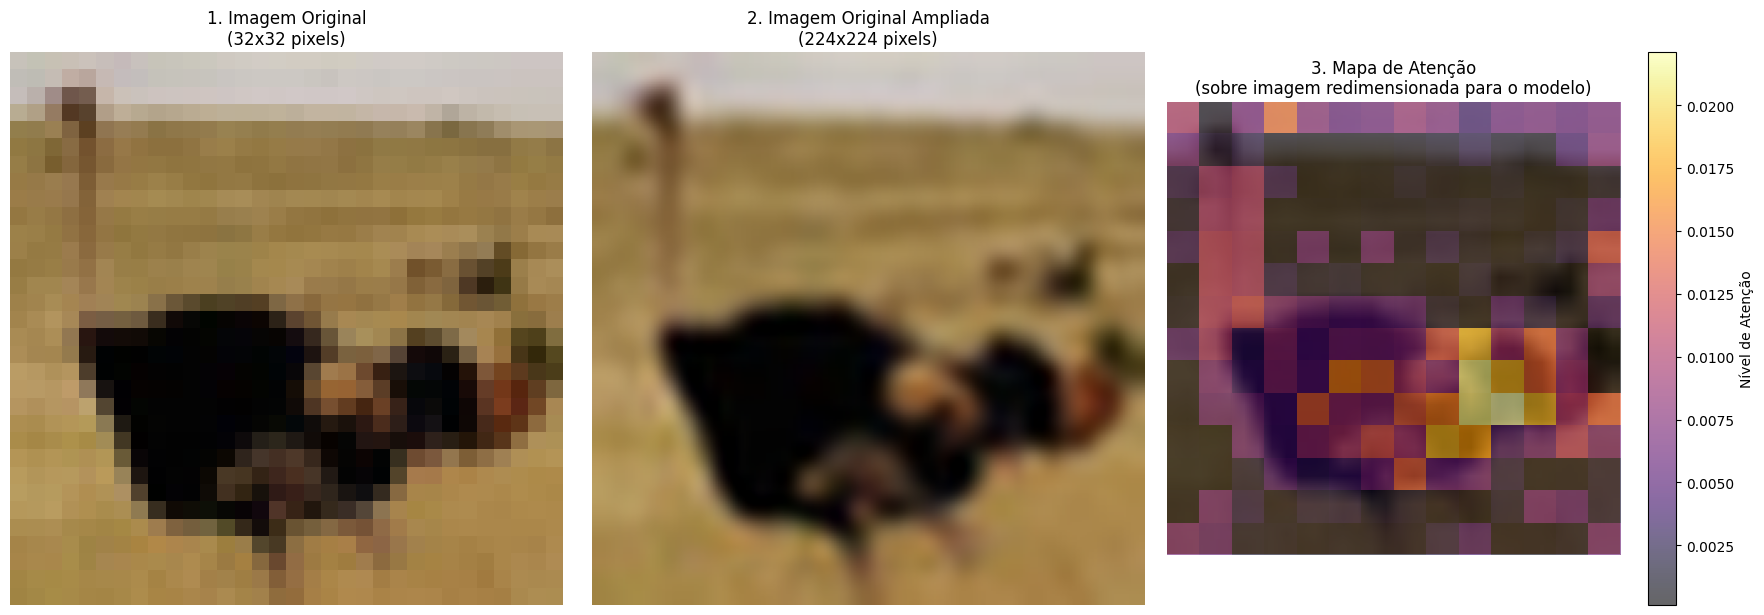

In [ ]:
import torch
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import random

model_name = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

print("Carregando o dataset cifar10...")
dataset = load_dataset("cifar10", split="test")

id_to_label = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

random_idx = random.randint(0, len(dataset) - 1)
sample = dataset[random_idx]
image_original = sample['img']
true_label_id = sample['label']
true_label_name = id_to_label[true_label_id]

if image_original.mode != 'RGB':
    image_original = image_original.convert('RGB')

inputs = feature_extractor(images=image_original, return_tensors="pt")
image_for_attention_plot = feature_extractor.resize(np.array(image_original), size=feature_extractor.size)

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
predicted_class_name = model.config.id2label[predicted_class_idx]

attentions = outputs.attentions[-1]
attention_map = attentions[0, :, 0, 1:].mean(dim=0)
attention_map = attention_map.reshape(14, 14)

print(f"Classe Real: {true_label_name}")
print(f"Previsão do ViT: {predicted_class_name}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(image_original)
ax1.set_title(f'1. Imagem Original\n({image_original.size[0]}x{image_original.size[1]} pixels)')
ax1.axis('off')

amplified_size = (224, 224)
image_amplified = image_original.resize(amplified_size, Image.Resampling.LANCZOS)

ax2.imshow(image_amplified)
ax2.set_title(f'2. Imagem Original Ampliada\n({amplified_size[0]}x{amplified_size[1]} pixels)')
ax2.axis('off')



im = ax3.imshow(attention_map.cpu().detach().numpy(), cmap='inferno', alpha=0.6, extent=(0, 224, 224, 0))
ax3.set_title(f'3. Mapa de Atenção\n(sobre imagem redimensionada para o modelo)')
ax3.axis('off')
fig.colorbar(im, ax=ax3, label='Nível de Atenção')

plt.tight_layout()
plt.show()

#ViT pré-treinado adaptado para o dataset CIFAR-10: treino, avaliação e inferência

100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/5, Loss: 0.1899
Epoch 2/5, Loss: 0.0976
Epoch 3/5, Loss: 0.0831
Epoch 4/5, Loss: 0.0634
Epoch 5/5, Loss: 0.0643
Accuracy: 94.62%


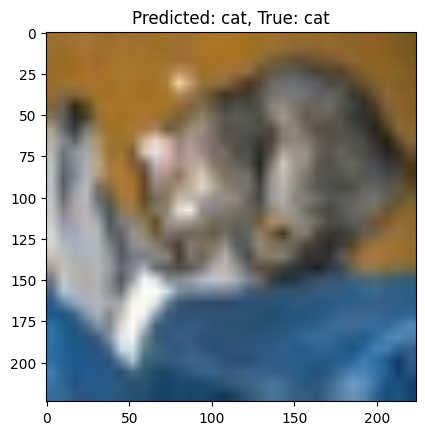

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import timm

# Configurações
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64
num_classes = 10
epochs = 5
learning_rate = 1e-4

# Transformações das imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT espera 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dataset CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Carregar um ViT pré-treinado
model = timm.create_model('vit_base_patch16_224', pretrained=True)
# Ajustar a cabeça de classificação para nosso número de classes
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Treinamento
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Avaliação
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

# Inferência em uma imagem de teste
import matplotlib.pyplot as plt
import numpy as np

image, label = test_dataset[0]
model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0).to(device))
    predicted_class = torch.argmax(output, 1).item()

classes = train_dataset.classes
plt.imshow(np.transpose(image.numpy(), (1,2,0)) * 0.5 + 0.5)  # desfaz a normalização
plt.title(f'Predicted: {classes[predicted_class]}, True: {classes[label]}')
plt.show()
